![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **Filter & Class Maximisation**

---


In this lesson, we use **Keras with a TensorFlow 2.0** to visualise the following (see below). This helps you gain a better understanding of what's going on under the hood and de-mystifies some of the deep learning aspects.**
1. Filter Maximisation
2. Class Maximisation

**References:**

https://github.com/keisen/tf-keras-vis



## **Maximizing Filter Activations**

The process is relatively simple in principle.
1. You’ll build a loss function that maximizes the value of a given filter in a given convolution layer
2. You’ll use Stochastic Gradient Descent to adjust the values of the input image so as to maximize this activation value. 

**NOTE** This is easier to implement in TF1.14 so we'll downgrade our Tensorflow package to make this work.

# **Visualising Conv Filters Maximisations**

Firstly, we need to install tf-keras-vis. https://github.com/keisen/tf-keras-vis

In [1]:
!pip install --upgrade tf-keras-vis tensorflow

     |████████████████████████████████| 53 kB 1.5 MB/s 


**Import our libraries**

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


### **Load a pretrained VGG16 model.**

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

#### **Firstly, we define a function to modify the model**

Define modifier to replace the model output to target layer's output that has filters you want to visualize.

In [4]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

### **Create ActivationMaximization Instance** 

If clone argument is True(default), the model will be cloned, so the model instance will be NOT modified, but it takes a machine resources.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model, model_modifier, clone=False)

### **Define Loss function**
You MUST define Loss function that return arbitrary filter values. Here, it returns the value corresponding third filter in block5_conv3 layer. ActivationMaximization will maximize the filter value.

In [6]:
filter_number = 7
def loss(output):
    return output[..., filter_number]

### **Visualize**
ActivationMaximization will maximize the model output value that is computed by the loss function. Here, we try to visualize a convolutional filter.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  after removing the cwd from sys.path.


Steps: 050	Scores: [[1160.5616455078125]],	Regularization: [('TotalVariation2D', [25.430862426757812]), ('Norm', [39.486568450927734])]
Steps: 100	Scores: [[1095.439453125]],	Regularization: [('TotalVariation2D', [20.23765754699707]), ('Norm', [40.38874053955078])]
Steps: 150	Scores: [[1133.8753662109375]],	Regularization: [('TotalVariation2D', [18.189022064208984]), ('Norm', [41.01130676269531])]
Steps: 200	Scores: [[1182.3402099609375]],	Regularization: [('TotalVariation2D', [15.03433895111084]), ('Norm', [41.55319595336914])]


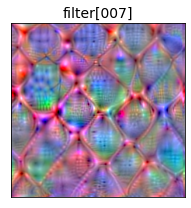

CPU times: user 8.48 s, sys: 634 ms, total: 9.11 s
Wall time: 14.9 s


In [7]:
%%time
from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss, callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
                 
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

## **Now let's visualize multiple convolutional filters**

#### **Define Loss function**
When visualizing multiple convolutional filters, you MUST define Loss function that return arbitrary filter values for each layer.

In [8]:
filter_numbers = [63, 132, 320]

# Define loss function that returns multiple filter outputs.
def loss(output):
    return (output[0, ..., 63], output[1, ..., 132], output[2, ..., 320])

#### **Create SeedInput values** 

And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)


#### **Visualize** 

Here, we will visualize 3 images while steps option is to be 512 to get clear images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  """


Steps: 050	Scores: [[1049.6732177734375, 829.7781982421875, 1141.3404541015625]],	Regularization: [('TotalVariation2D', [25.988662719726562, 22.430273056030273, 26.046367645263672]), ('Norm', [39.367916107177734, 38.280120849609375, 39.515235900878906])]
Steps: 100	Scores: [[1008.9328002929688, 731.0010986328125, 974.3536987304688]],	Regularization: [('TotalVariation2D', [20.044469833374023, 17.02309799194336, 20.048311233520508]), ('Norm', [40.18061447143555, 38.83171463012695, 40.353275299072266])]
Steps: 150	Scores: [[991.2421264648438, 792.42138671875, 1054.6649169921875]],	Regularization: [('TotalVariation2D', [17.164264678955078, 15.192628860473633, 18.047550201416016]), ('Norm', [40.67293167114258, 39.21356964111328, 40.974403381347656])]
Steps: 200	Scores: [[851.0617065429688, 629.6723022460938, 959.2533569335938]],	Regularization: [('TotalVariation2D', [14.62614917755127, 12.922548294067383, 15.981249809265137]), ('Norm', [41.02055740356445, 39.510032653808594, 41.447906494140

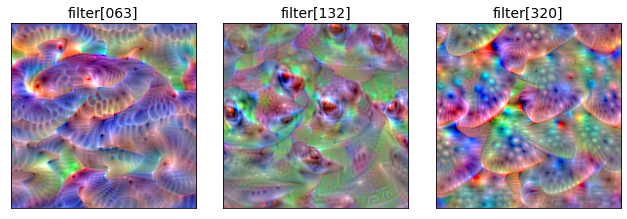

CPU times: user 14.3 s, sys: 179 ms, total: 14.5 s
Wall time: 14.4 s


In [10]:
%%time

# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
    
plt.tight_layout()
plt.show()

# **Class Maximisation** 

Finding an input that maximizes a specific class of VGGNet.

#### **Load libaries and load your pretrained VGG16 Model**

Load tf.keras.Model¶
This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.


In [11]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

1 GPUs
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

#### **Define a function to modify the model**

Define modifier to replace a softmax function of the last layer to a linear function.

In [12]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

#### **Create ActivationMaximization Instance**

If clone argument is True(default), the model will be cloned, so the model instance will be NOT modified, but it takes a machine resources.

In [13]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

#### **Define Loss function**

You MUST define Loss function that return arbitrary category value. Here, we try to visualize a category as defined No.20 (ouzel) of imagenet.



In [14]:
def loss(output):
    return output[:, 20]

### **Visualise**

The Imagenet Classes - https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  """


Steps: 050	Scores: [[202.8544464111328]],	Regularization: [('TotalVariation2D', [19.91523551940918]), ('Norm', [36.39292907714844])]
Steps: 100	Scores: [[243.83351135253906]],	Regularization: [('TotalVariation2D', [14.97299861907959]), ('Norm', [36.48286056518555])]
Steps: 150	Scores: [[276.76593017578125]],	Regularization: [('TotalVariation2D', [13.111485481262207]), ('Norm', [36.575321197509766])]
Steps: 200	Scores: [[263.7285461425781]],	Regularization: [('TotalVariation2D', [11.130213737487793]), ('Norm', [36.66991424560547])]


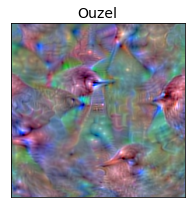

CPU times: user 7.89 s, sys: 158 ms, total: 8.05 s
Wall time: 7.94 s


In [15]:
%%time

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('Ouzel', fontsize=14)
plt.tight_layout()
plt.show()


### **Visualizing specific output categories** 

Now, let's visualize multiple categories at once!

#### **Define Loss function**

You MUST define loss function that return arbitrary category values. Here, we try to visualize categories as defined No.1 (Goldfish), No.294 (Bear) and No.413 (Assault rifle) of imagenet.


In [16]:
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

def loss(output):
    return (output[0, 1], output[1, 294], output[2, 413])

#### **Create SeedInput values** 
And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [17]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

#### **Visualize**

Here, we will visualize 3 images while steps option is to be 512 to get clear images.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  


Steps: 050	Scores: [[434.94189453125, 265.4527587890625, 178.6334991455078]],	Regularization: [('TotalVariation2D', [20.45862579345703, 20.475313186645508, 19.056232452392578]), ('Norm', [37.3758430480957, 36.587158203125, 35.2987174987793])]
Steps: 100	Scores: [[456.6398010253906, 248.947021484375, 169.85887145996094]],	Regularization: [('TotalVariation2D', [15.702065467834473, 15.797894477844238, 15.057597160339355]), ('Norm', [37.856689453125, 36.96156311035156, 35.32332992553711])]
Steps: 150	Scores: [[418.9059143066406, 243.4579315185547, 184.84962463378906]],	Regularization: [('TotalVariation2D', [12.671394348144531, 12.69810962677002, 12.486780166625977]), ('Norm', [38.16211700439453, 37.173763275146484, 35.38949203491211])]
Steps: 200	Scores: [[452.9491882324219, 277.0712585449219, 230.7278289794922]],	Regularization: [('TotalVariation2D', [11.699769973754883, 11.505532264709473, 12.01763916015625]), ('Norm', [38.40645980834961, 37.32164001464844, 35.6185188293457])]
Steps: 250

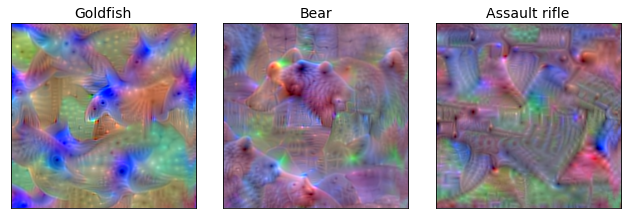

CPU times: user 36.7 s, sys: 448 ms, total: 37.1 s
Wall time: 36.9 s


In [18]:
%%time

# Do 500 iterations and Generate an optimizing animation
activations = activation_maximization(loss,
                                      seed_input=seed_input,
                                      steps=512,
                                      callbacks=[ Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()

plt.show()